## Hamza Khurshid
### Deep Learning Group 2
### CMS: 372135

# Autoencoders and Variational Autoencoders


In [ ]:
# !pip install imgaug

In [1]:
## load the libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 640x480 with 0 Axes>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/DL-Lab12/fashion_mnist.zip" -d "/content/drive/MyDrive/DL-Lab12"

Archive:  /content/drive/MyDrive/DL-Lab12/fashion_mnist.zip
  inflating: /content/drive/MyDrive/DL-Lab12/fashion-mnist_test.csv  
   creating: /content/drive/MyDrive/DL-Lab12/__MACOSX/
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/._fashion-mnist_test.csv  
  inflating: /content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/._fashion-mnist_train.csv  


## Part 1: Data

### Reading data

Download the data given at the following link: <insert_link>. Use pandas and numpy to read in the data as a matrix

In [3]:
### read dataset
train = pd.read_csv("/content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.15)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.15)

In [4]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [5]:
train_x.shape

(43350, 28, 28, 1)

### Visualizing Samples

Visualize 10 images from dataset

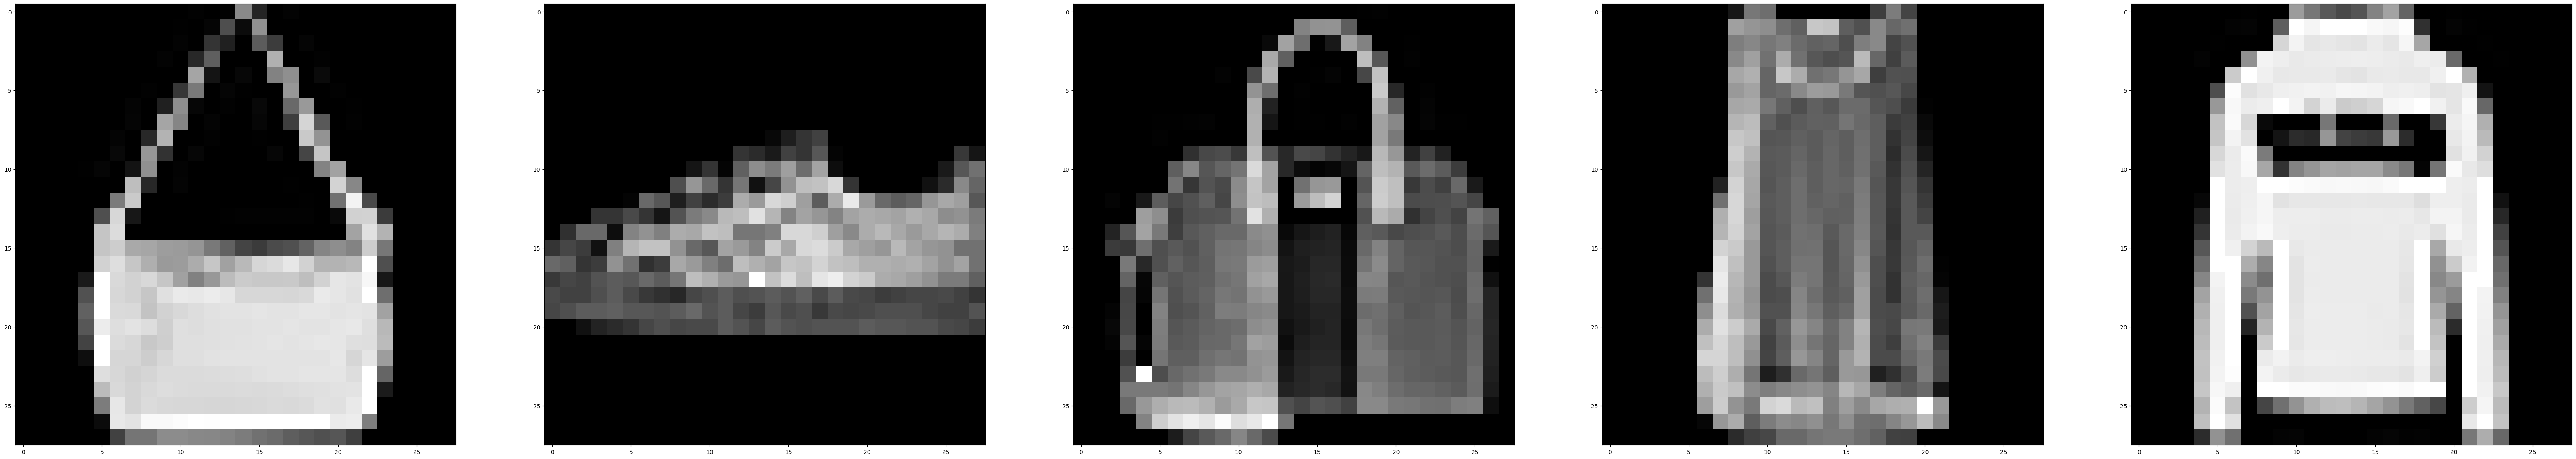

In [6]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i, :, :, 0].reshape(28, 28))

## Part 2: Denoise Images using AEs

### Understanding AEs

![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

### Add Noise to Images

Check out [imgaug docs](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html) for more info and other ways to add noise.

In [7]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

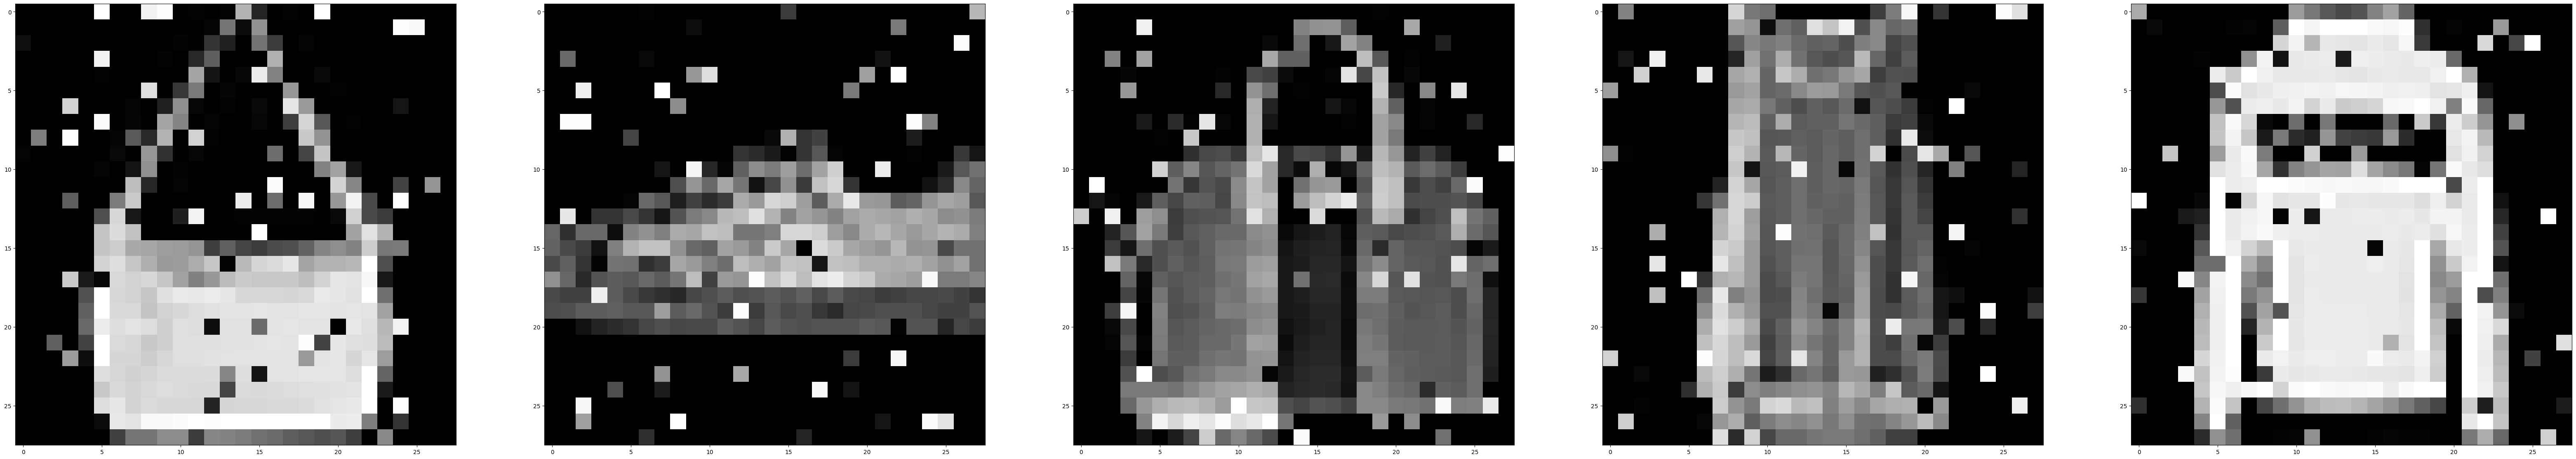

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [9]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [10]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

### Train AE

In [11]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
22/22 [==============================] - 16s 283ms/step - loss: 0.0906 - val_loss: 0.0605
Epoch 2/10
22/22 [==============================] - 2s 107ms/step - loss: 0.0492 - val_loss: 0.0395
Epoch 3/10
22/22 [==============================] - 2s 98ms/step - loss: 0.0358 - val_loss: 0.0325
Epoch 4/10
22/22 [==============================] - 2s 97ms/step - loss: 0.0308 - val_loss: 0.0286
Epoch 5/10
22/22 [==============================] - 2s 98ms/step - loss: 0.0273 - val_loss: 0.0257
Epoch 6/10
22/22 [==============================] - 2s 103ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 7/10
22/22 [==============================] - 2s 104ms/step - loss: 0.0237 - val_loss: 0.0230
Epoch 8/10
22/22 [==============================] - 2s 99ms/step - loss: 0.0228 - val_loss: 0.0231
Epoch 9/10
22/22 [==============================] - 2s 98ms/step - loss: 0.0222 - val_loss: 0.0216
Epoch 10/10
22/22 [==============================] - 2s 97ms/step - loss: 0.0214 - val_loss: 0.0209


### Visualize Intermediate Layers of AE

Visualize intermediate layers

In [14]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

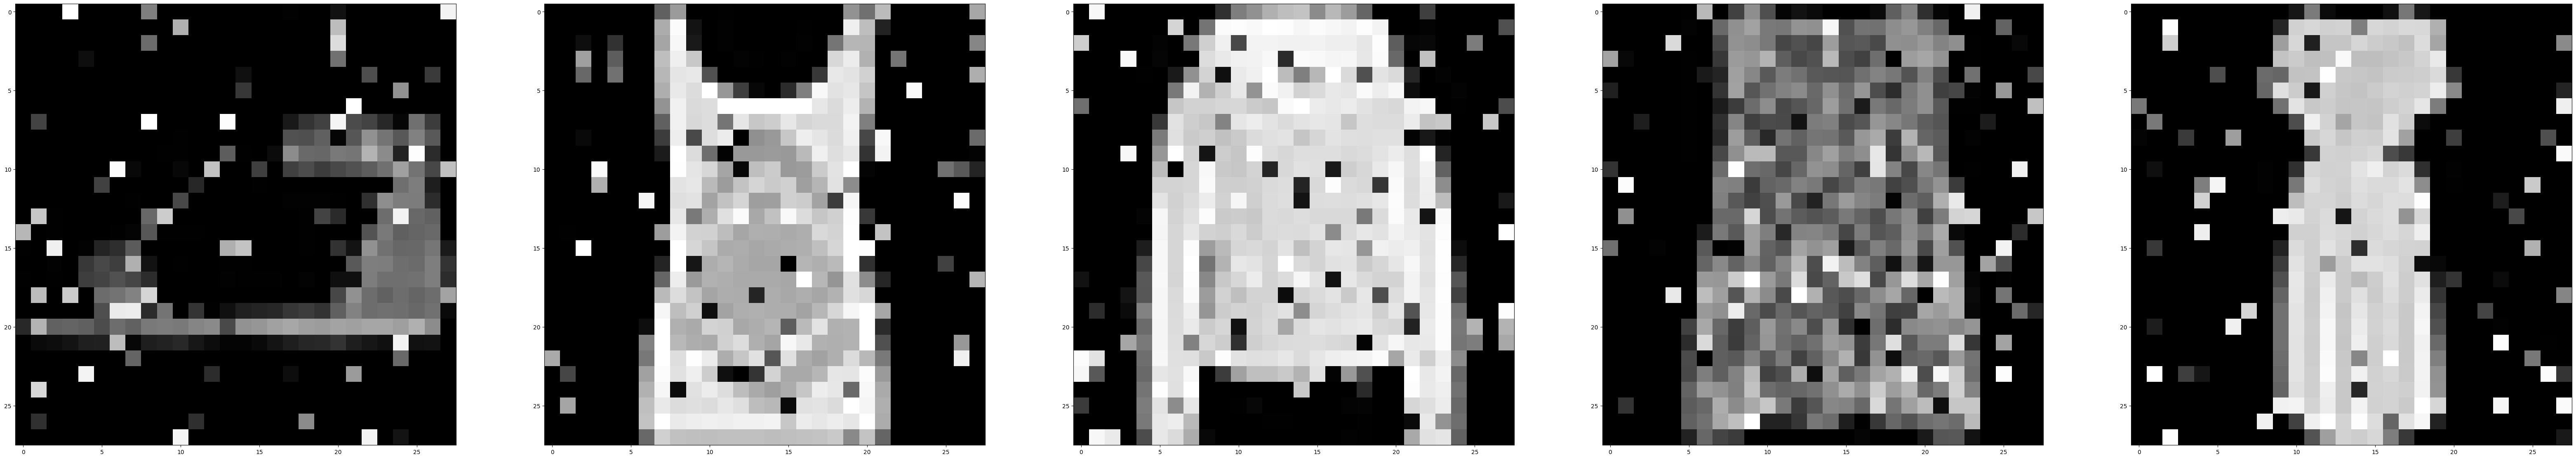

In [15]:
n = np.random.randint(0,len(val_x)-5)
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))
plt.show()

In [16]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

1/1 [==============================] - 0s 211ms/step


(5, 4, 4, 16)

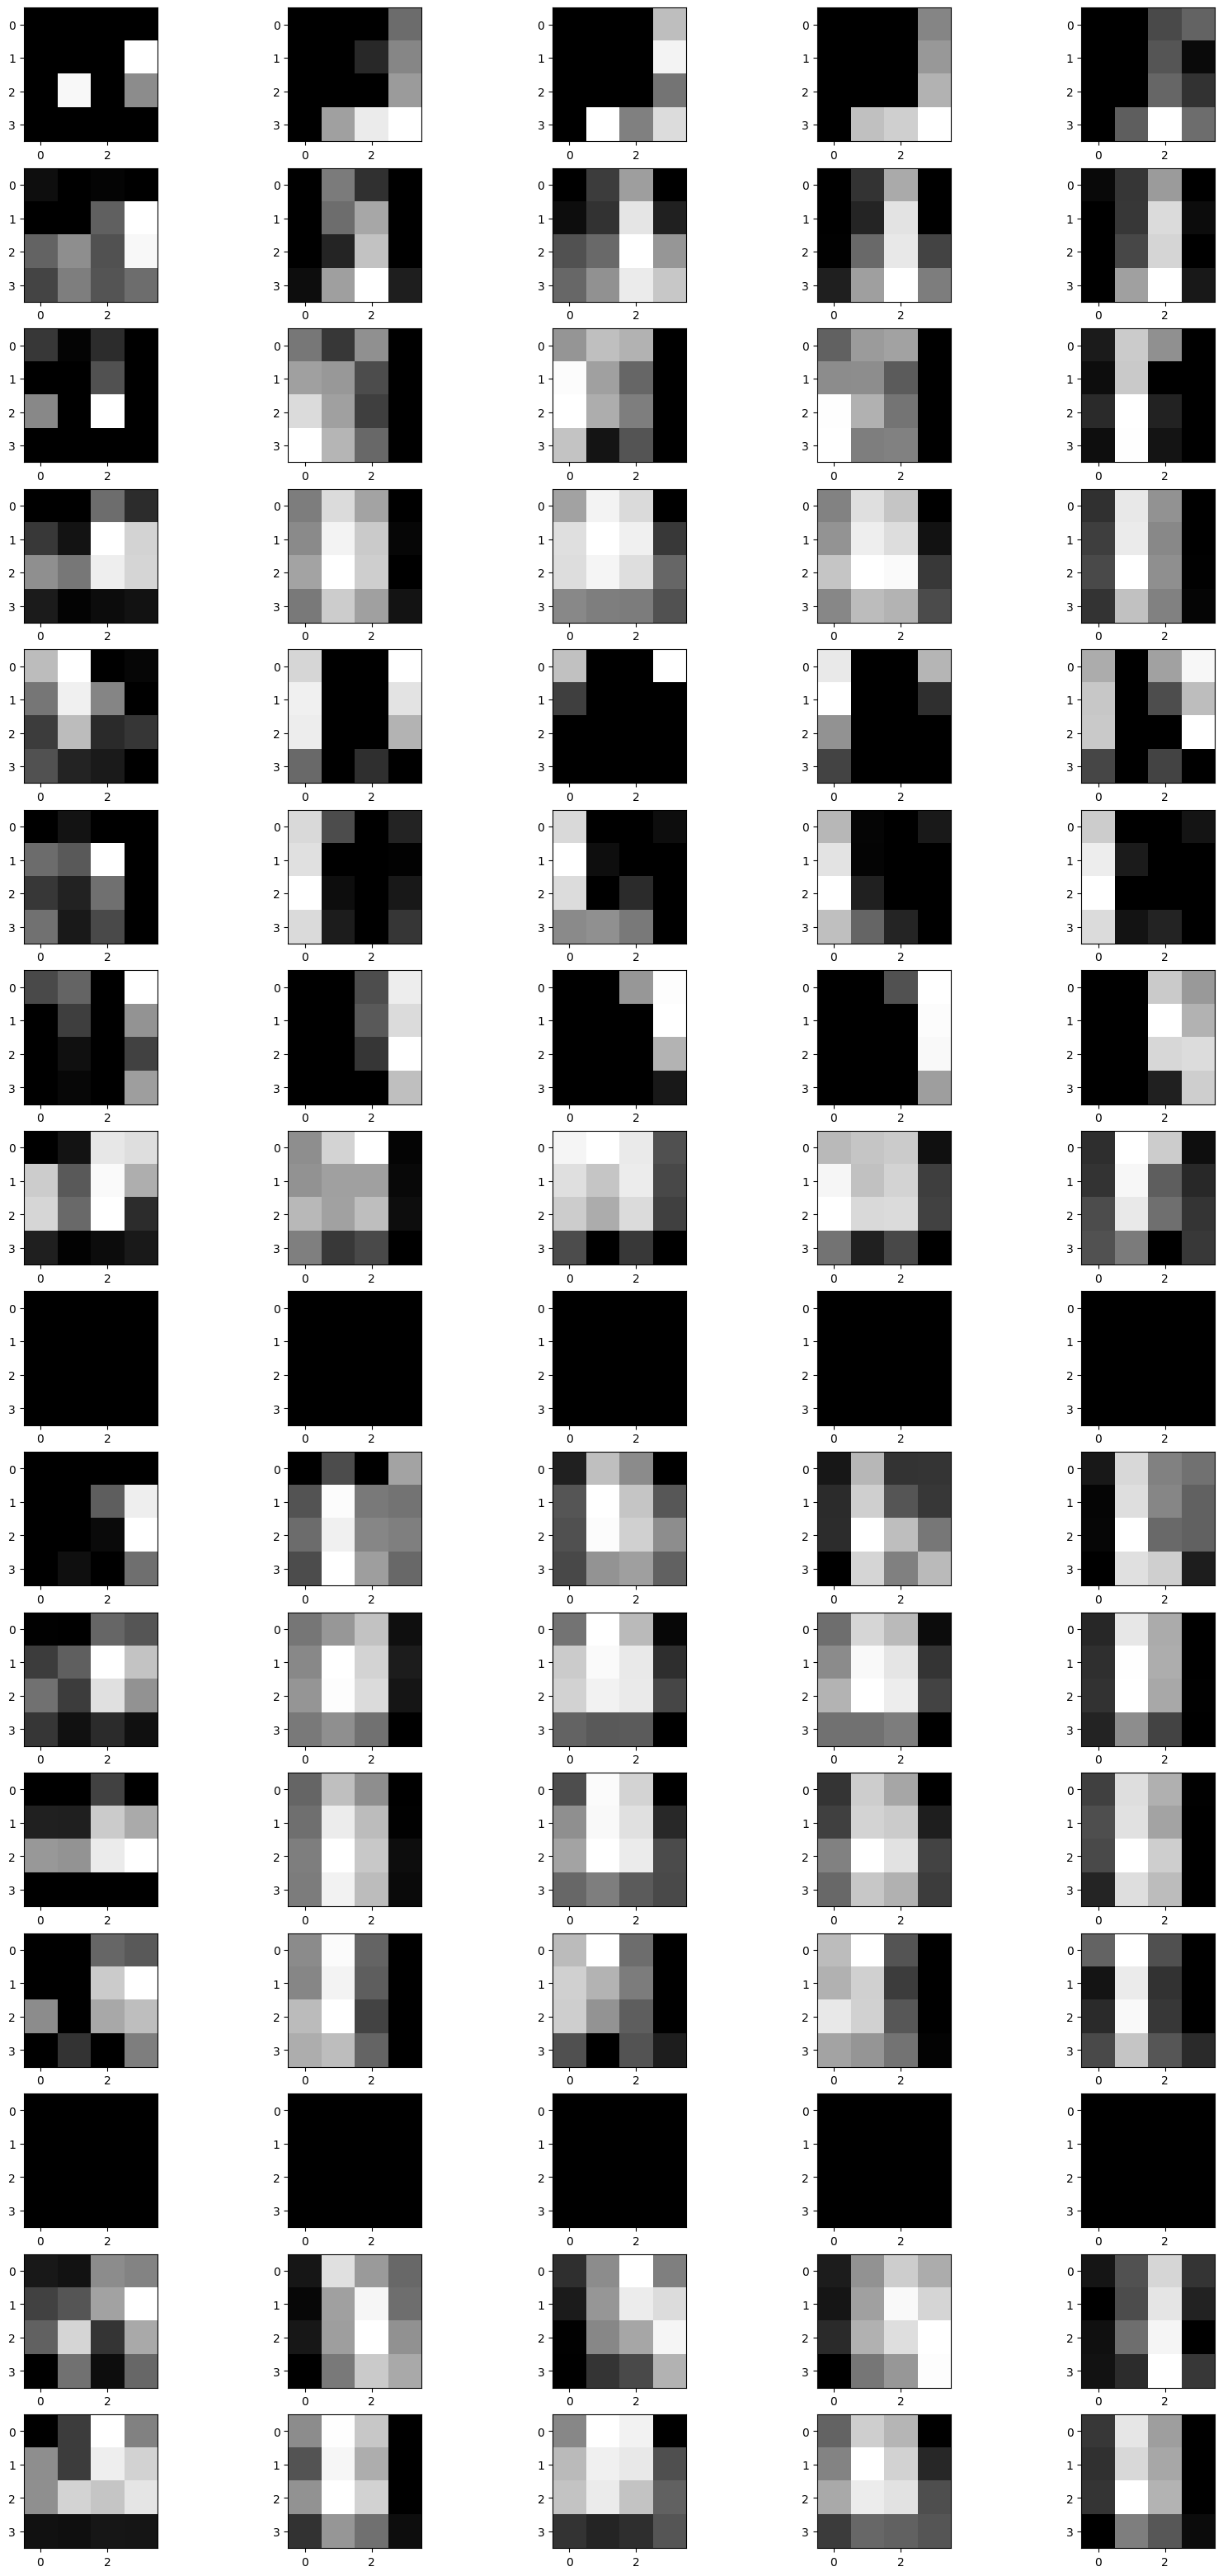

In [17]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()

### Visualize Samples reconstructed by AE

In [18]:
n = np.random.randint(0,len(val_x)-5)

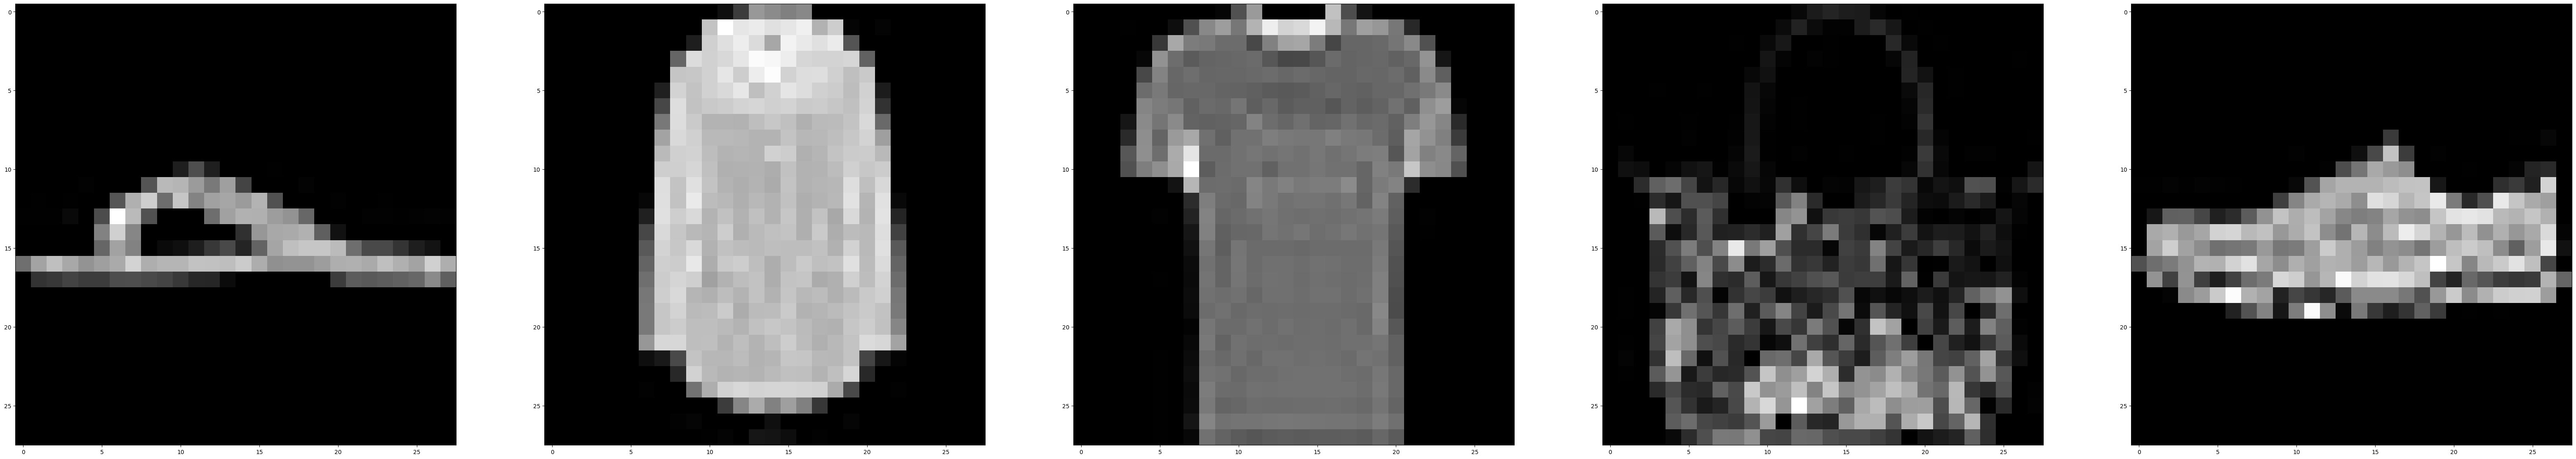

In [19]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x[a, :, :, 0].reshape(28, 28))

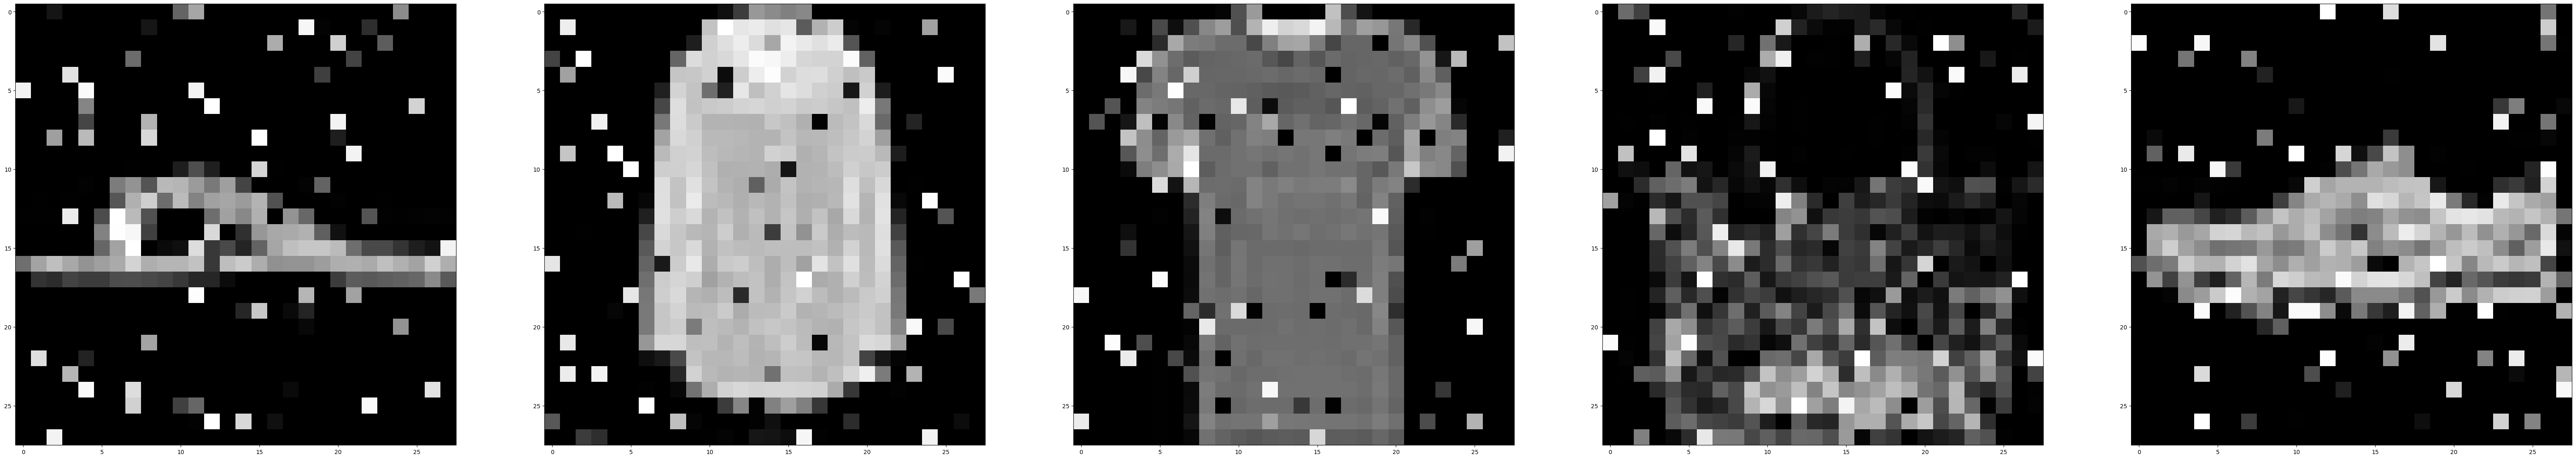

In [20]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

1/1 [==============================] - 0s 270ms/step


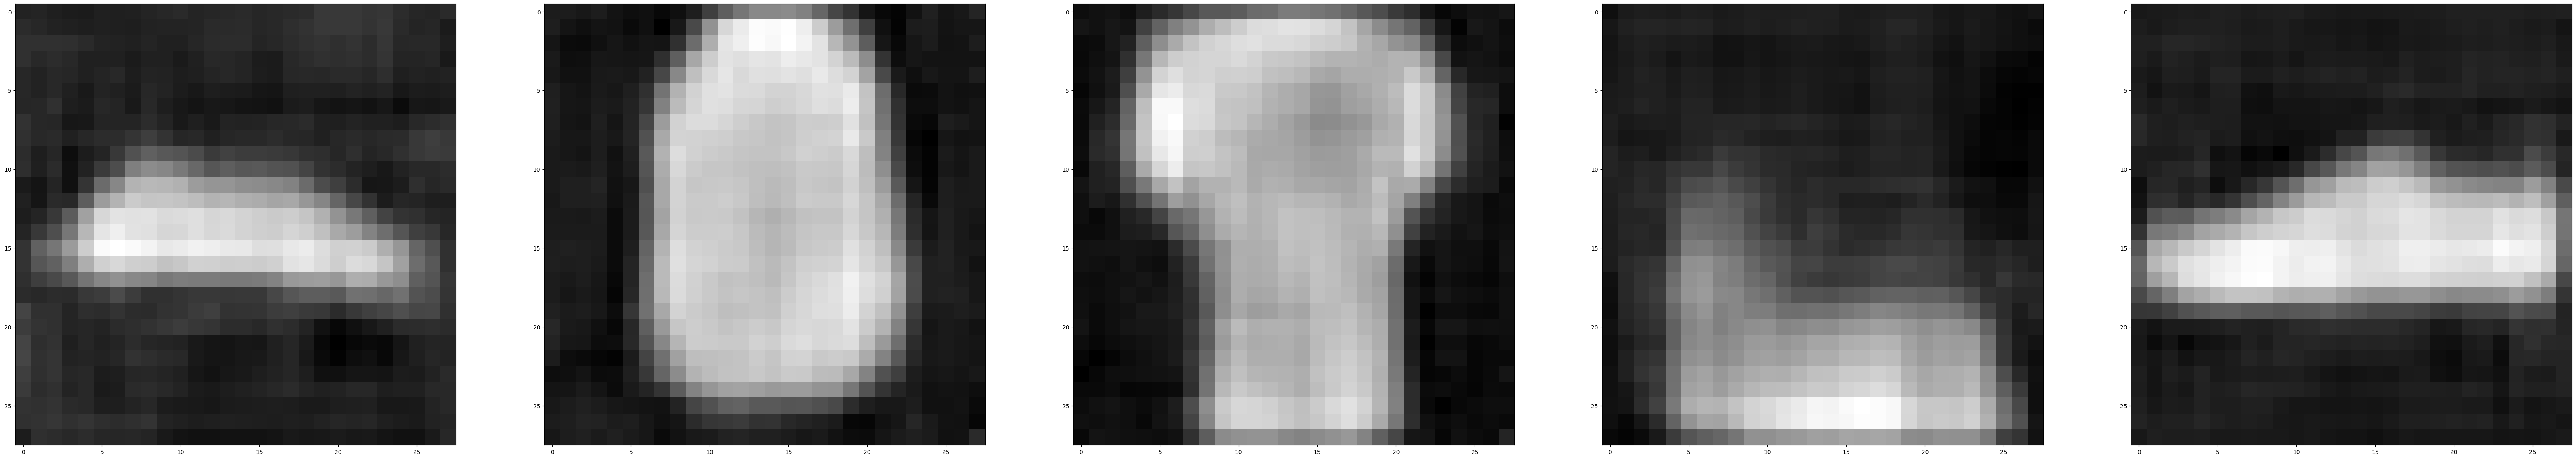

In [21]:
preds = model.predict(val_x_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## Part 3: Exercise: Denoising noisy documents

In [22]:
!unzip "/content/drive/MyDrive/DL-Lab12/noisy_docs_data.zip" -d "/content/drive/MyDrive/DL-Lab12"

Archive:  /content/drive/MyDrive/DL-Lab12/noisy_docs_data.zip
   creating: /content/drive/MyDrive/DL-Lab12/test/
  inflating: /content/drive/MyDrive/DL-Lab12/test/88.png  
   creating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._88.png  
  inflating: /content/drive/MyDrive/DL-Lab12/test/214.png  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._214.png  
  inflating: /content/drive/MyDrive/DL-Lab12/test/76.png  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._76.png  
  inflating: /content/drive/MyDrive/DL-Lab12/test/163.png  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._163.png  
  inflating: /content/drive/MyDrive/DL-Lab12/test/175.png  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._175.png  
  inflating: /content/drive/MyDrive/DL-Lab12/test/202.png  
  inflating: /content/drive/MyDrive/DL-Lab12/__MACOSX/test/._202.png  
  inflating: /content/drive/MyDrive/DL-Lab12/

In [23]:
TRAIN_IMAGES = glob.glob('/content/drive/MyDrive/DL-Lab12/train/*.png')
CLEAN_IMAGES = glob.glob('/content/drive/MyDrive/DL-Lab12/train_cleaned/*.png')
TEST_IMAGES = glob.glob('/content/drive/MyDrive/DL-Lab12/test/*.png')

(420, 540)


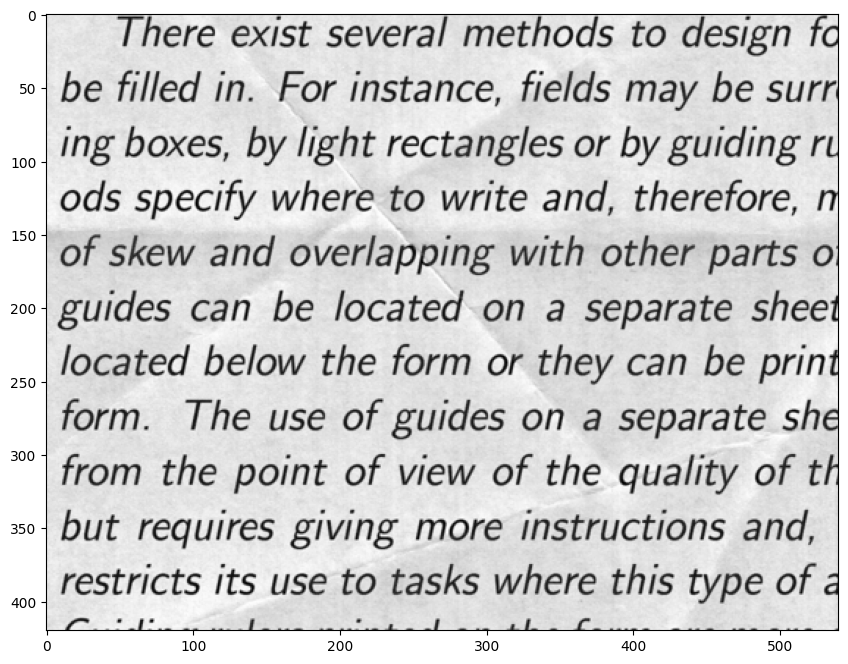

In [25]:
plt.figure(figsize=(20,8))
img = cv2.imread('/content/drive/MyDrive/DL-Lab12/train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [26]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x

    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [27]:
#Todo: Split your dataset into train and val
from sklearn.model_selection import train_test_split

# Define the percentage of data to be used for validation
validation_split = 0.2

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)


Training data shape: (115, 258, 540, 1)
Validation data shape: (29, 258, 540, 1)


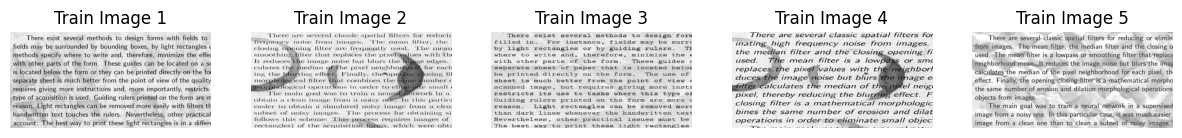

In [28]:
#Todo: Visualize your train set

import matplotlib.pyplot as plt

# Define a function to visualize images
def visualize_images(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):  # Plot the first 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'{title} Image {i + 1}')
    plt.show()

# Visualize some sample images from the training set
visualize_images(x_train, 'Train')


In [29]:
input_layer = Input(shape=(258, 540, 1))

#Todo: Setup encoder
#Hint: Conv2D - > MaxPooling

# Encoder
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

#Todo: Setup decoder
#Hint: Conv2D - > Upsampling

# Decoder
decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)

output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

ae = Model(input_layer, output_layer)

In [30]:
#Todo: Compile and summarize your auto encoder

# Compile the autoencoder
ae.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summarize the autoencoder
ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 258, 540, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 258, 540, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 129, 270, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 129, 270, 16)      2320      
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 258, 540, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 258, 540, 1)       145 

In [31]:
#Todo: Train your autoencoder

# Train the autoencoder
history = ae.fit(x_train, y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 7s 864ms/step - loss: 0.2455 - val_loss: 0.2252
Epoch 2/10
4/4 [==============================] - 0s 86ms/step - loss: 0.2130 - val_loss: 0.1927
Epoch 3/10
4/4 [==============================] - 0s 84ms/step - loss: 0.1807 - val_loss: 0.1628
Epoch 4/10
4/4 [==============================] - 0s 90ms/step - loss: 0.1512 - val_loss: 0.1328
Epoch 5/10
4/4 [==============================] - 0s 87ms/step - loss: 0.1209 - val_loss: 0.1040
Epoch 6/10
4/4 [==============================] - 0s 89ms/step - loss: 0.0942 - val_loss: 0.0834
Epoch 7/10
4/4 [==============================] - 0s 91ms/step - loss: 0.0773 - val_loss: 0.0742
Epoch 8/10
4/4 [==============================] - 0s 84ms/step - loss: 0.0710 - val_loss: 0.0726
Epoch 9/10
4/4 [==============================] - 0s 86ms/step - loss: 0.0705 - val_loss: 0.0733
Epoch 10/10
4/4 [==============================] - 0s 80ms/step - loss: 0.0710 - val_loss: 0.0733


In [32]:
preds = ae.predict(x_test)

3/3 [==============================] - 1s 218ms/step


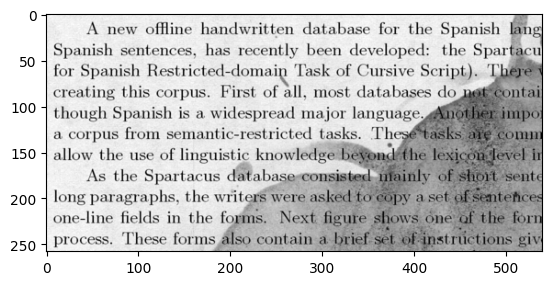

In [33]:
n = 25
preds_0 = preds[n] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[n] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

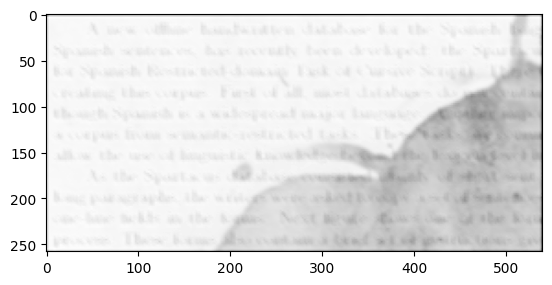

In [34]:
plt.imshow(preds_0, cmap='gray')

## Part 4: Generating New Fashion using VAEs

### Understanding VAEs

!["VAE"](http://www.cvc.uab.es/people/joans/slides_tensorflow/tensorflow_html/vae_files/ae.png)

### Reset data

In [35]:
### read dataset
train = pd.read_csv("/content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.2)

In [36]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [37]:
import keras.backend as K

In [38]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [39]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [40]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [41]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dens  (None, 512)               1536      
 e)                                                              
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [43]:
z_decoded

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_3')>

In [44]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [45]:
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 intermediate_encoder (Dens  (None, 512)                  401920    ['input[0][0]']               
 e)                                                                                               
                                                                                                  
 latent_encoder (Dense)      (None, 2)                    1026      ['intermediate_encoder[0][0]']
                                                                                                  
 dense (Dense)               (None, 2)                    6         ['latent_encoder[0][0]']

In [46]:
train_x.shape

(38400, 28, 28, 1)

In [47]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [48]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Epoch 1/20
2400/2400 [==============================] - 16s 5ms/step - loss: 0.4134 - val_loss: 0.3587
Epoch 2/20
2400/2400 [==============================] - 10s 4ms/step - loss: 0.3511 - val_loss: 0.3467
Epoch 3/20
2400/2400 [==============================] - 11s 5ms/step - loss: 0.3440 - val_loss: 0.3407
Epoch 4/20
2400/2400 [==============================] - 9s 4ms/step - loss: 0.3402 - val_loss: 0.3372
Epoch 5/20
2400/2400 [==============================] - 10s 4ms/step - loss: 0.3377 - val_loss: 0.3362
Epoch 6/20
2400/2400 [==============================] - 11s 5ms/step - loss: 0.3359 - val_loss: 0.3340
Epoch 7/20
2400/2400 [==============================] - 9s 4ms/step - loss: 0.3343 - val_loss: 0.3340
Epoch 8/20
2400/2400 [==============================] - 10s 4ms/step - loss: 0.3328 - val_loss: 0.3313
Epoch 9/20
2400/2400 [==============================] - 10s 4ms/step - loss: 0.3316 - val_loss: 0.3301
Epoch 10/20
2400/2400 [==============================] - 9s 4ms/step - loss

1/1 [==============================] - 0s 15ms/step


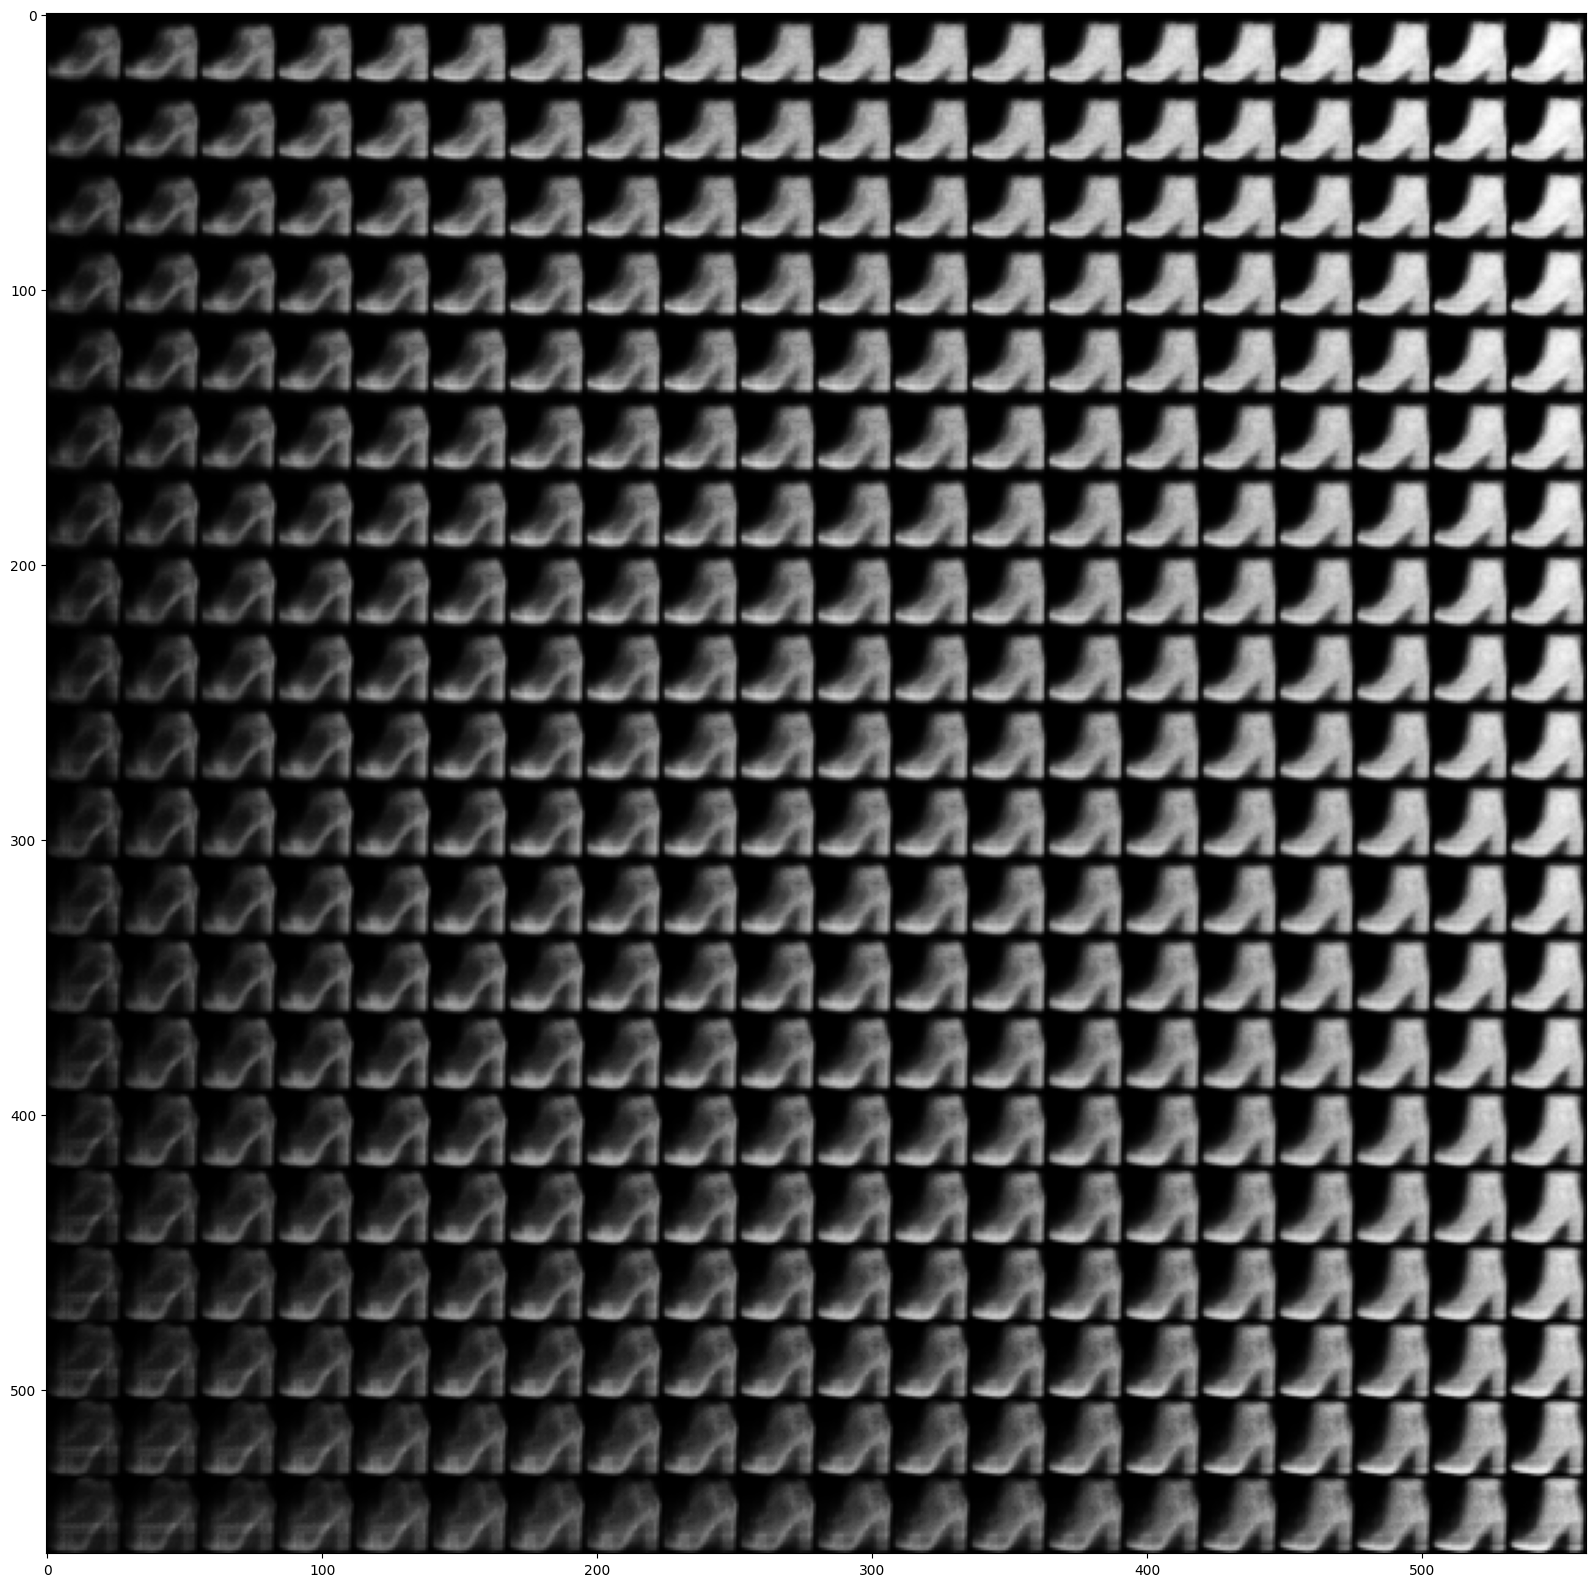

In [49]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

3750/3750 [==============================] - 7s 2ms/step


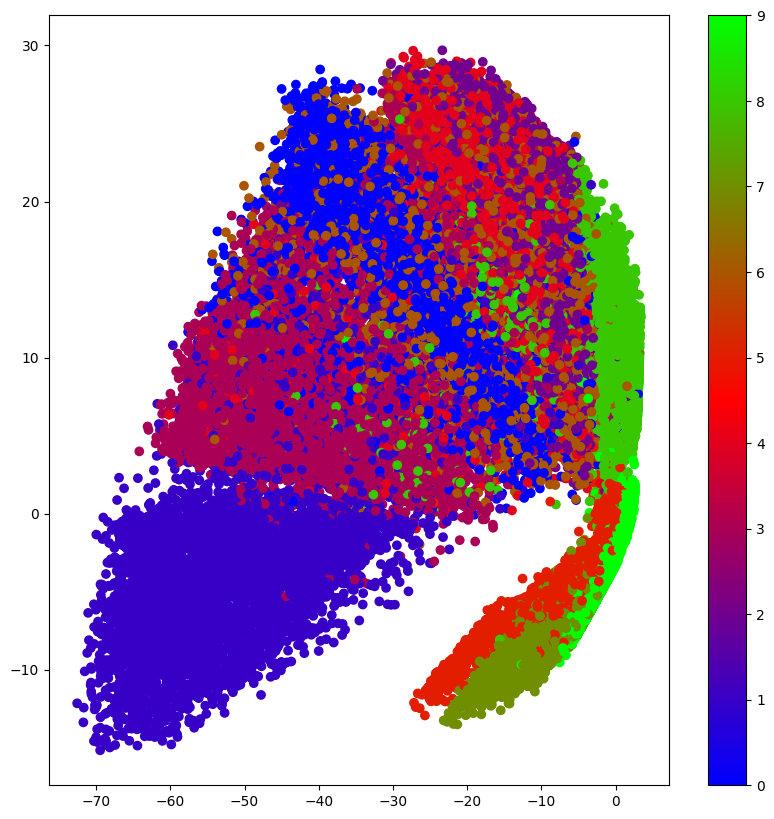

In [50]:
### read dataset
train = pd.read_csv("/content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
# train_x = train_x.reshape(-1, 28, 28, 1)

# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

## Part 5: Exercise: Generating New Fashion using VAEs: Adding CNNs and KL Divergence Loss

In [51]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Hint: Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))


#Todo: Setup encoder network
# Encoder architecture
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# Combine into a model
encoder = Model(input_img, [z_mu, z_log_sigma])


### Set up sampling function

In [52]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [53]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

#Todo: Setup decoder network
#Hint Expand to 784 pixels -> reshape -> Conv2Dtranspose -> conv2D

# Expand to 6272 (7x7x128) pixels
x = Dense(7 * 7 * 128, activation='relu')(decoder_input)

# Reshape to 7x7x128
x = Reshape((7, 7, 128))(x)

# Upsample to 14x14x128
x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)

# Upsample to 28x28x64
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)

# 28x28x1 output
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Set up loss functions

In [55]:
# construct a custom layer to calculate the loss

def vae_loss(self, x, z_decoded, z_mu, z_log_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]  # Mean of the encoded latent space
        z_log_sigma = inputs[3]  # Log variance of the encoded latent space
        loss = self.vae_loss(x, z_decoded, z_mu, z_log_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])

### Train VAE

In [56]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [57]:
vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 28, 28, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_11[0][0]']           
                                                                                            

In [59]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [60]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Epoch 1/20
3750/3750 [==============================] - 29s 7ms/step - loss: 0.3513 - val_loss: 0.3330
Epoch 2/20
3750/3750 [==============================] - 32s 9ms/step - loss: 0.3319 - val_loss: 0.3273
Epoch 3/20
3750/3750 [==============================] - 25s 7ms/step - loss: 0.3273 - val_loss: 0.3238
Epoch 4/20
3750/3750 [==============================] - 24s 6ms/step - loss: 0.3246 - val_loss: 0.3223
Epoch 5/20
3750/3750 [==============================] - 23s 6ms/step - loss: 0.3231 - val_loss: 0.3207
Epoch 6/20
3750/3750 [==============================] - 24s 6ms/step - loss: 0.3219 - val_loss: 0.3199
Epoch 7/20
3750/3750 [==============================] - 24s 6ms/step - loss: 0.3210 - val_loss: 0.3180
Epoch 8/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.3202 - val_loss: 0.3175
Epoch 9/20
3750/3750 [==============================] - 23s 6ms/step - loss: 0.3195 - val_loss: 0.3176
Epoch 10/20
3750/3750 [==============================] - 23s 6ms/step - l

### Visualize Samples reconstructed by VAE

1/1 [==============================] - 0s 17ms/step


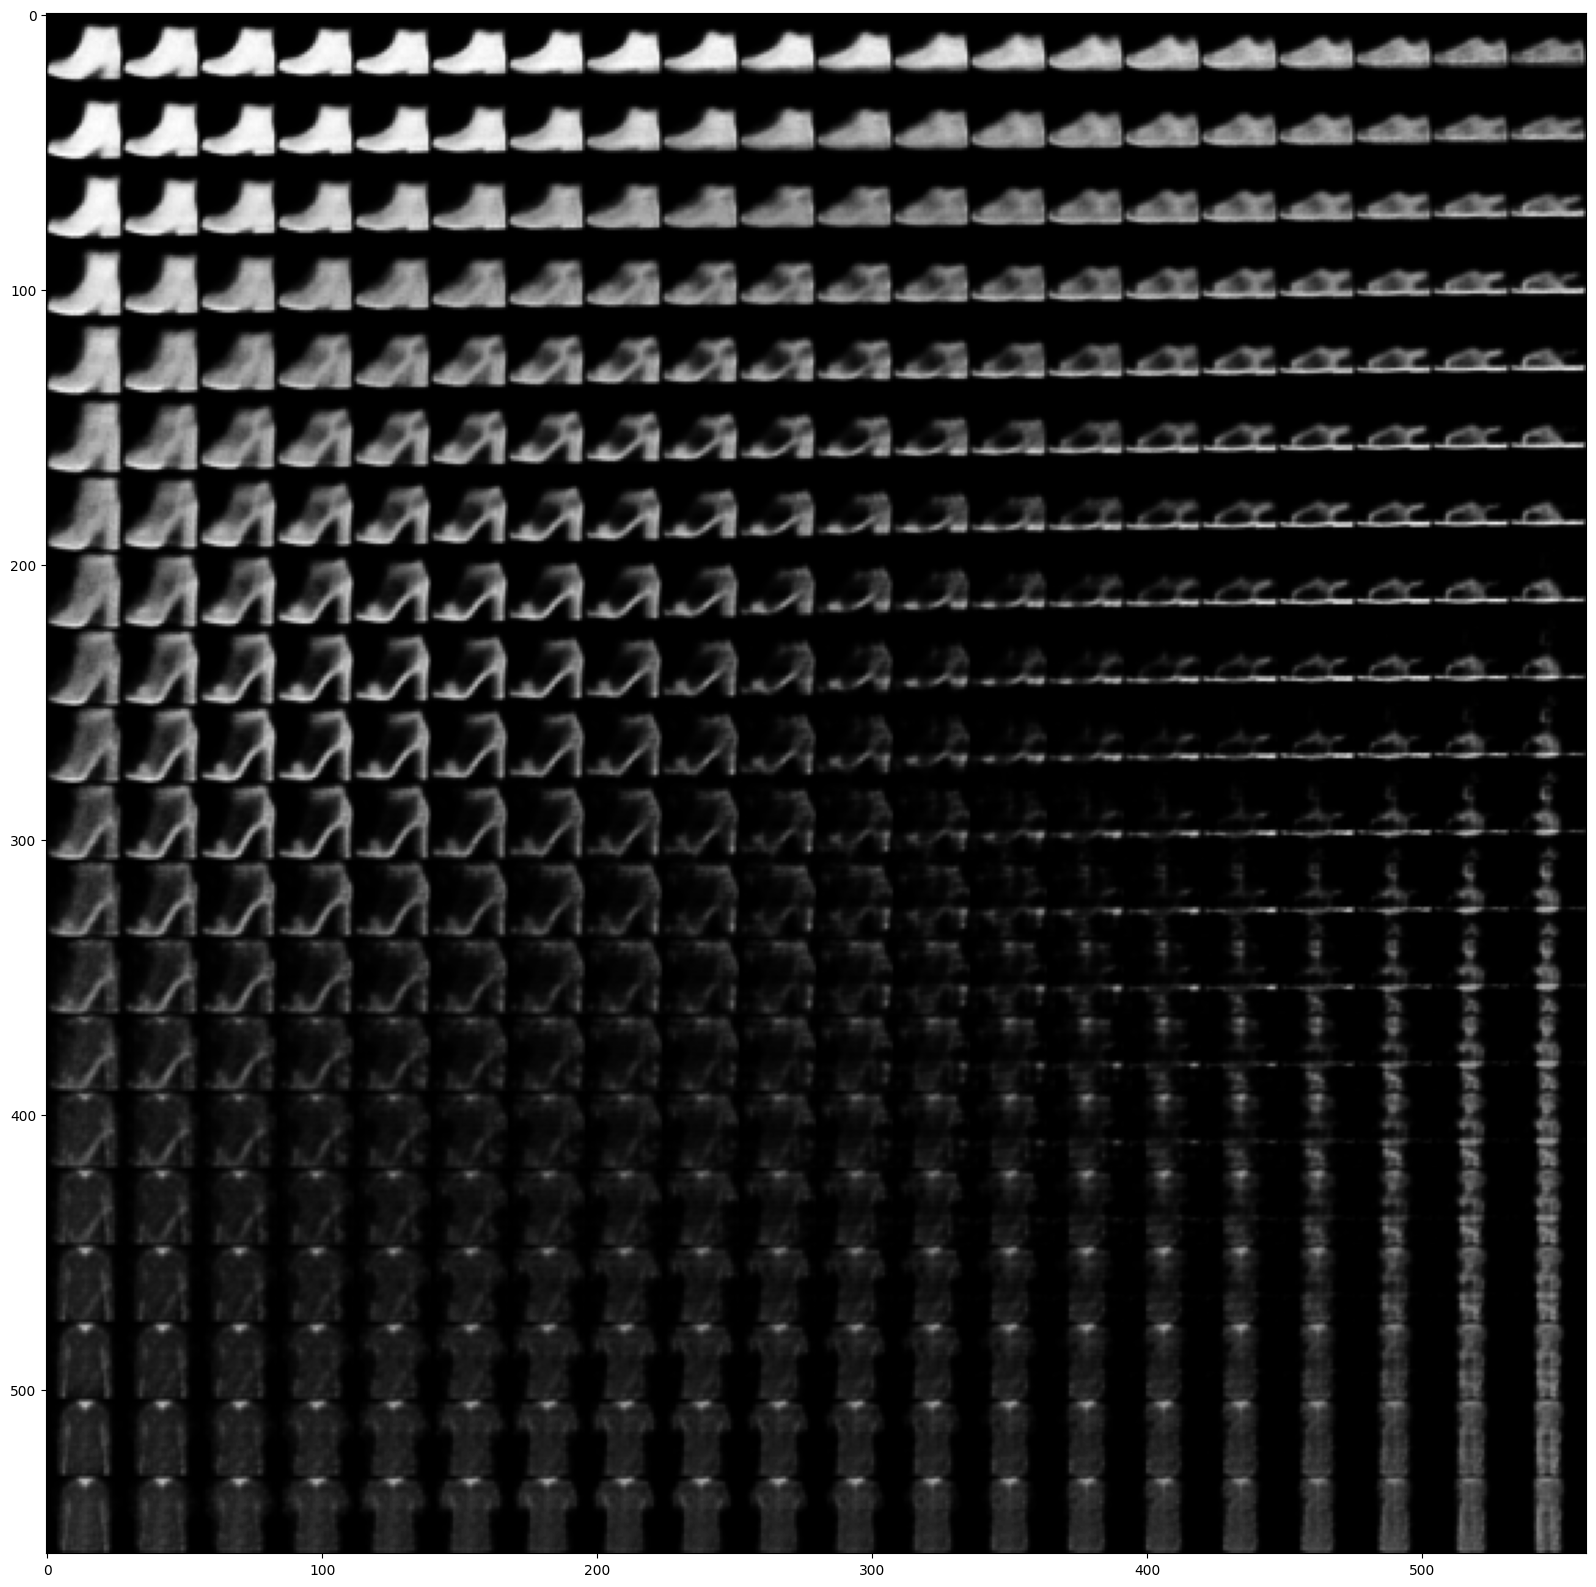

In [61]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

## Exercise: Visualize latent space

In [62]:
train = pd.read_csv("/content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv")

In [63]:
### read dataset
train = pd.read_csv("/content/drive/MyDrive/DL-Lab12/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
train_x = train_x.reshape(-1, 28, 28, 1)

3750/3750 [==============================] - 8s 2ms/step


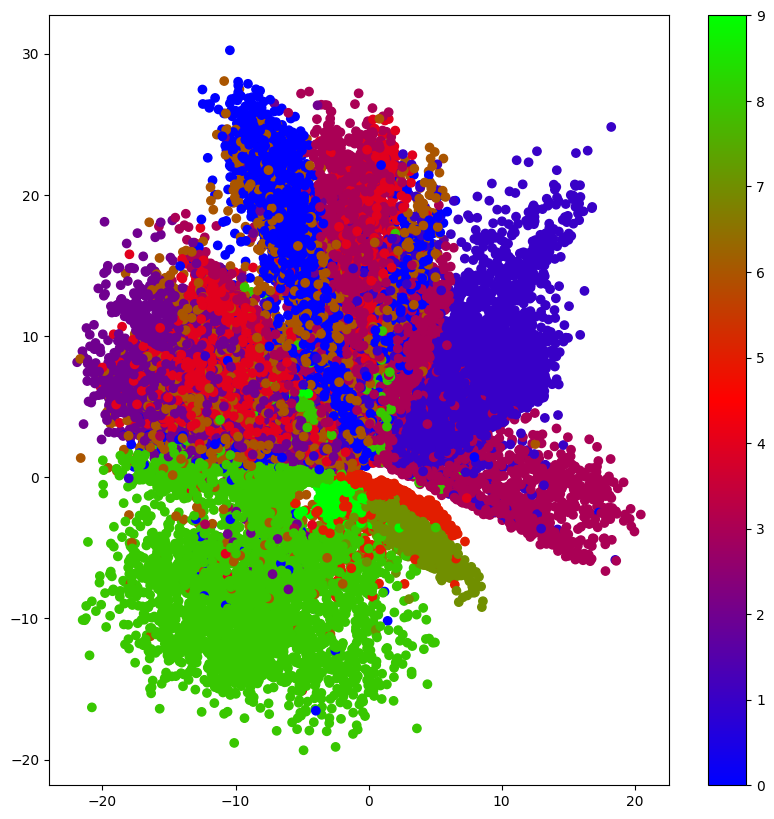

In [64]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()